In [1]:
import pandas as pd
import numpy as np

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def load_data(file_name):
    return pd.read_csv(file_name)


In [4]:
sales_data = load_data('C:\\Final Year Project\\Dataset\\train.csv')
df_s = sales_data.copy()
df_s = df_s[::1500]

In [5]:
df_s

,date,store,item,sales
0,2013-01-01,1,1,13
1700,2017-08-28,1,1,15
3400,2017-04-24,2,1,35
5100,2016-12-19,3,1,21
6800,2016-08-15,4,1,15
...,...,...,...,...
906100,2014-02-09,7,50,38
907800,2013-10-06,8,50,88
909500,2013-06-02,9,50,72
911200,2013-01-27,10,50,42


<AxesSubplot:>

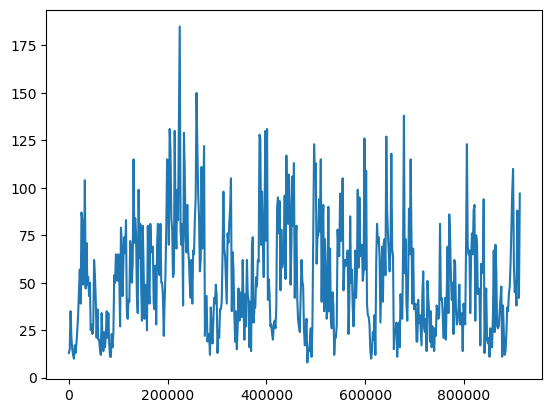

In [6]:
df_s['sales'].plot()

In [7]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data

In [8]:
m_df = monthlyORyears_sales(df_s,"monthly")
m_df.head(10)

,date,sales
0,2013-01-01,113
1,2013-02-01,463
2,2013-03-01,55
3,2013-04-01,739
4,2013-05-01,133
5,2013-06-01,832
6,2013-07-01,191
7,2013-08-01,728
8,2013-09-01,214
9,2013-10-01,554


In [9]:
y_df = monthlyORyears_sales(df_s,"years")
y_df


,date,sales
0,2013-01-01,4685
1,2014-01-01,5218
2,2015-01-01,5779
3,2016-01-01,6073
4,2017-01-01,6547


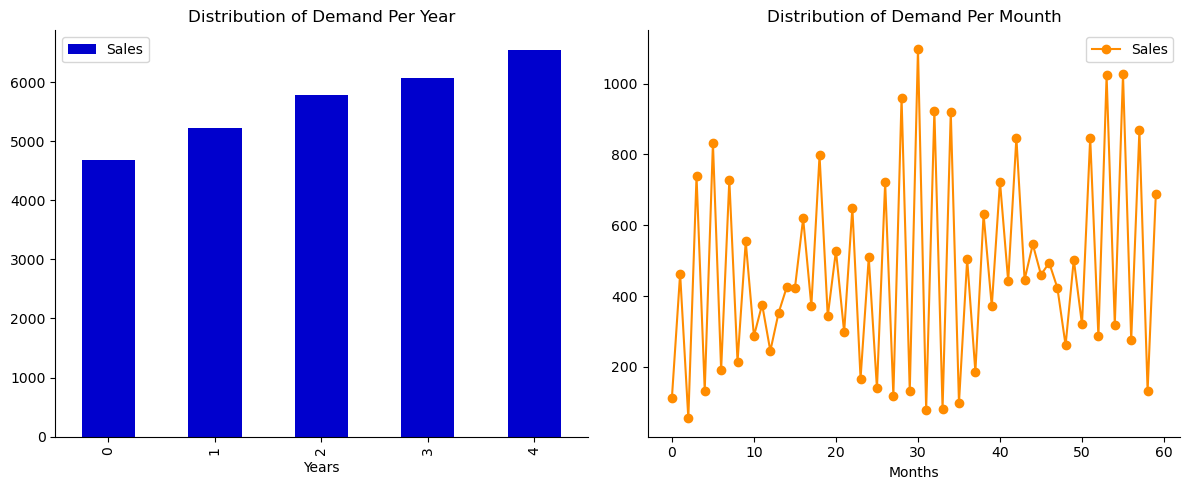

In [10]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df['sales'].plot(kind = "bar",color = 'mediumblue', label="Sales",ax=raw, figsize=(12,5))
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Demand Per Year")
months.set(xlabel = "Months", title = "Distribution of Demand Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

In [11]:
def sales_time(data):

    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")

In [12]:
sales_time(df_s)

Days: 1824
Years: 4
Month: 48


In [13]:
def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkred')
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
    return sales_by_store

,store,sales
0,1,2547
1,2,3782
2,3,3330
3,4,2933
4,5,2200
5,6,2114
6,7,1890
7,8,3470
8,9,2931
9,10,3105


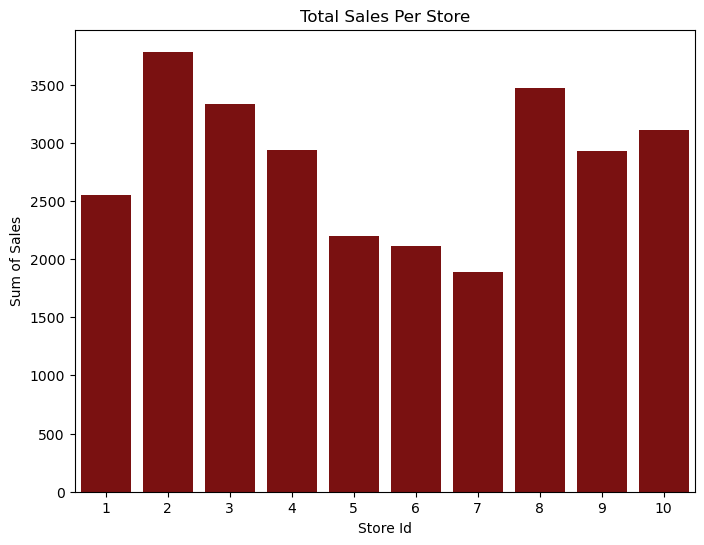

In [14]:
sales_per_store(df_s)

In [15]:
average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
    average_m_sales_1y = m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall Avarage Monthly Sales: $471.7
Last 12 months average monthly sales: $545.5833333333334


In [16]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x_col, y_col, data = data, ax = ax, color = 'darkblue', label='Total Sales')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot((s_mean.date + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)

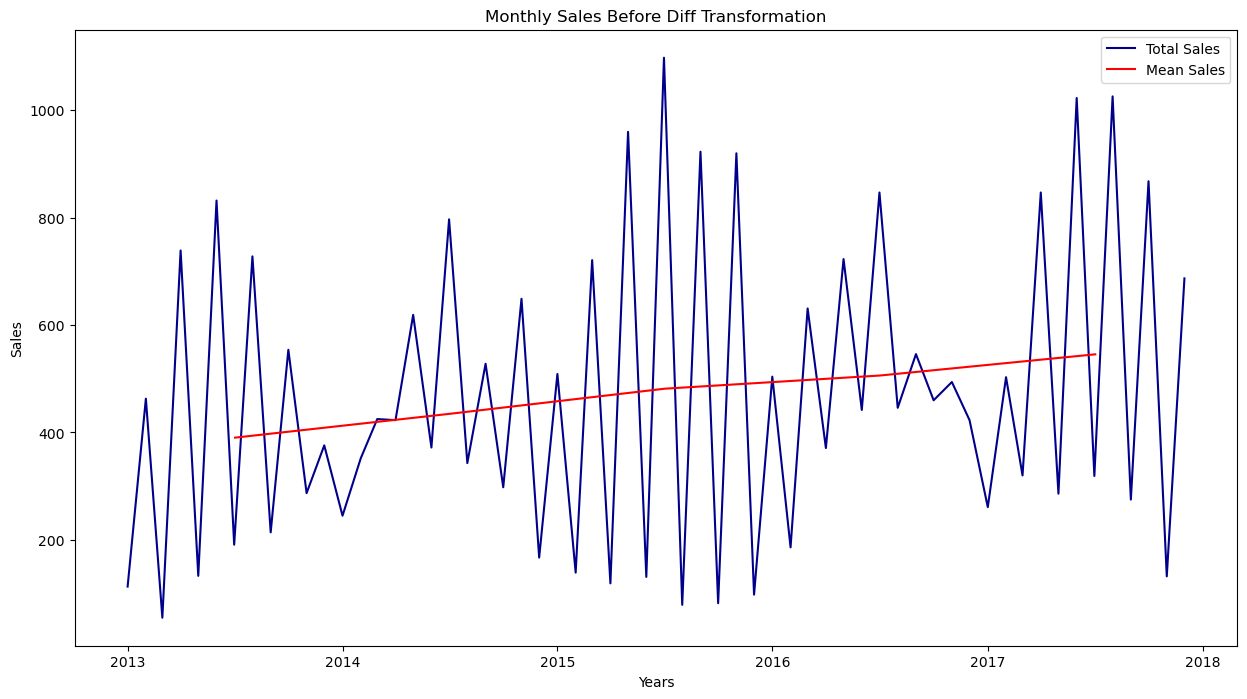

In [17]:
time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation' )

In [18]:
def get_diff(data):
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    return data

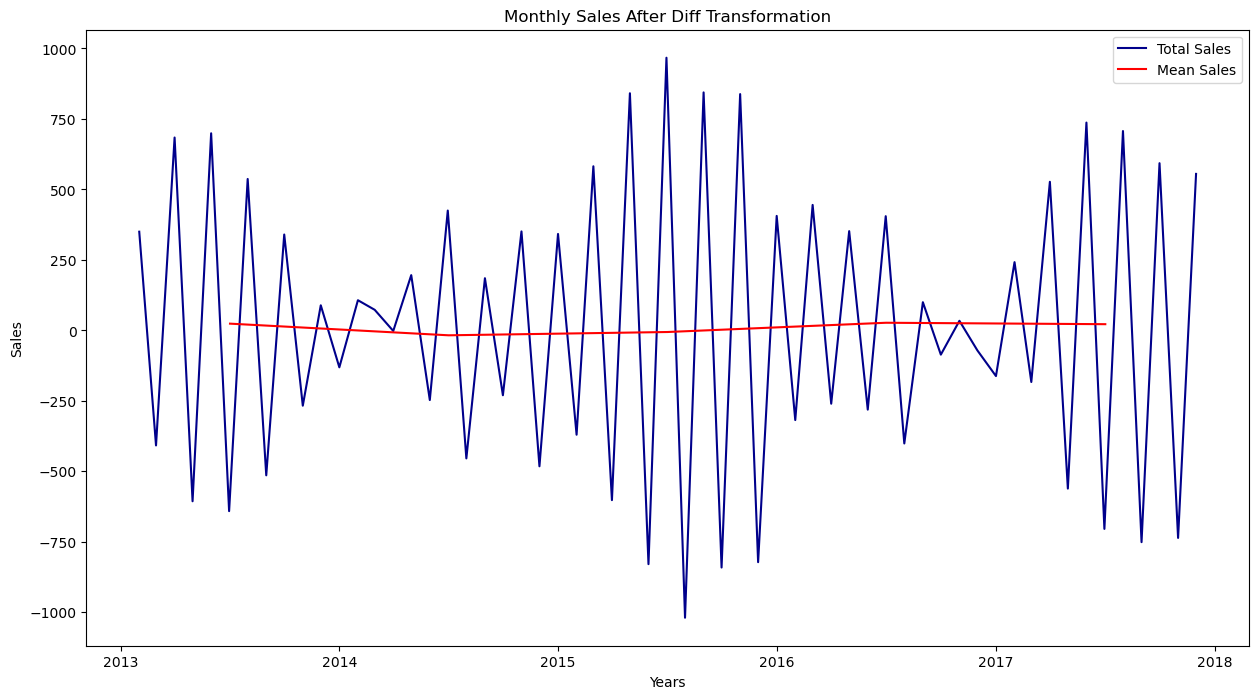

In [19]:
stationary_df = get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Monthly Sales After Diff Transformation')

In [20]:
def built_supervised(data):
    supervised_df = data.copy()

    for i in range(1, 10):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df

In [21]:
model_df = built_supervised(stationary_df)
model_df 

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,2013-11-01,287,-267.0,340.0,-514.0,537.0,-641.0,699.0,-606.0,684.0,-408.0,350.0
1,2013-12-01,376,89.0,-267.0,340.0,-514.0,537.0,-641.0,699.0,-606.0,684.0,-408.0
2,2014-01-01,245,-131.0,89.0,-267.0,340.0,-514.0,537.0,-641.0,699.0,-606.0,684.0
3,2014-02-01,352,107.0,-131.0,89.0,-267.0,340.0,-514.0,537.0,-641.0,699.0,-606.0
4,2014-03-01,425,73.0,107.0,-131.0,89.0,-267.0,340.0,-514.0,537.0,-641.0,699.0
5,2014-04-01,423,-2.0,73.0,107.0,-131.0,89.0,-267.0,340.0,-514.0,537.0,-641.0
6,2014-05-01,619,196.0,-2.0,73.0,107.0,-131.0,89.0,-267.0,340.0,-514.0,537.0
7,2014-06-01,372,-247.0,196.0,-2.0,73.0,107.0,-131.0,89.0,-267.0,340.0,-514.0
8,2014-07-01,797,425.0,-247.0,196.0,-2.0,73.0,107.0,-131.0,89.0,-267.0,340.0
9,2014-08-01,343,-454.0,425.0,-247.0,196.0,-2.0,73.0,107.0,-131.0,89.0,-267.0


In [22]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-8].values, data[-8:].values
    
    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (42, 10)
Shape of  Test: (8, 10)


In [23]:
def scale_data(train_set,test_set):
    

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    

    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() 
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (42, 9)
Shape of y Train: (42,)
Shape of X Test: (8, 9)
Shape of y Test: (8,)


In [24]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    
    
    y_pred = y_pred.reshape(y_pred.shape[0],1,1)

    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1) )

        
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])


    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

In [25]:
def prediction_df(unscale_predictions, origin_df):
    
    result_list = []
    sales_dates = list(origin_df[-9:].date)
    act_sales = list(origin_df[-9:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [26]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-8:], 
                                      unscale_df.pred_value[-8:]))
    
    mae = mean_absolute_error(origin_df.sales[-8:], 
                              unscale_df.pred_value[-8:])
    
    r2 = r2_score(origin_df.sales[-8:], 
                  unscale_df.pred_value[-8:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [27]:
def plot_results(results, origin_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(origin_df.date, origin_df.sales, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Demand Trends",
           title = f"{model_name} Demand Forecasting Prediction")
    
    ax.legend(loc='best')
    
    filepath = Path('./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./model_output/{model_name}_forecasting.svg')

In [28]:
def regressive_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)

    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object)
    unscaled_df = prediction_df(unscaled, origin_df)

    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)

RMSE: 78.54457333259886
MAE: 62.5
R2 Score: 0.9473710027597326


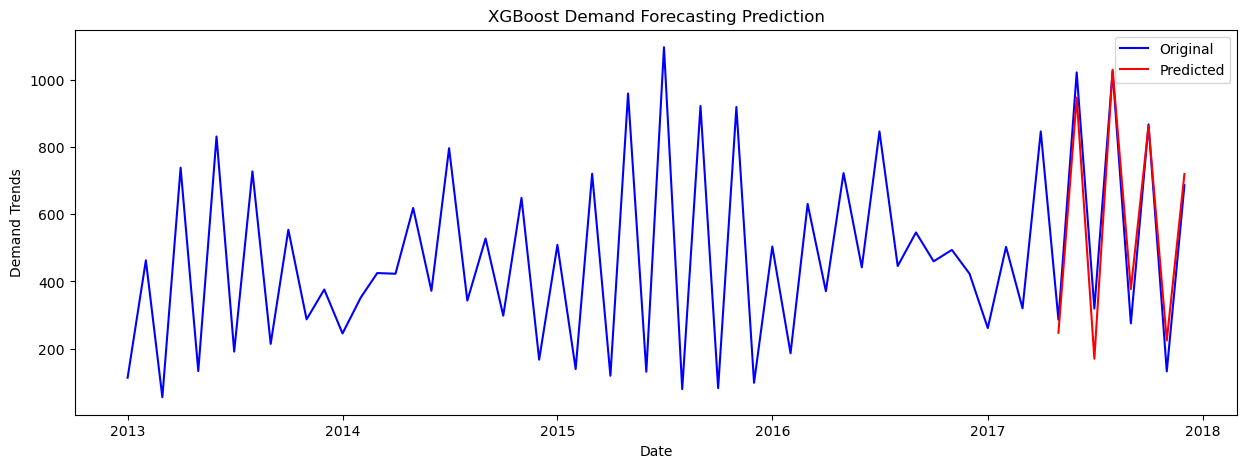

In [29]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=1, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')